The two most popular implementations of Boosting Trees are [XGBoost](https://en.wikipedia.org/wiki/XGBoost) and [LightGBM](https://en.wikipedia.org/wiki/LightGBM). In this notebook we use XGBoost.

## Analyzing the performance of the resulting classifier.
In this notebook we look into the result of running XGBoost on the Whale Classification problem. We are interested in two things:

* **Accuracy:**   A classifier is accurate if it makes few errors.

* **Stability / Confidence**  A classifier is stable if replacing the training set causes only small change in the predictions. An abstaining classifier outputs "IDK" when on examples where the prediction is unstable.

In [1]:
%pylab inline
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from lib import XGBHelper as xgbh

from lib.logger import logger

%load_ext autoreload

%autoreload 2

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/Users/yoavfreund/miniforge3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
f'Version of xgb={xgb.__version__}, should be at least 1.5.1'

'Version of xgb=1.5.1, should be at least 1.5.1'

## Loading Data

The data files were preprocessed on PySpark (10 nodes) cluster. The code for the same can be found [here](Data_Processing_Whales.ipynb). The preprocessed is a numpy array with `4175` rows (for the 10mb file) with following columns (zero-indexed):
* Col 0-9: projections on first 10 eigen vectors
* Col 10: rmse
* Col 11: peak2peak
* Col 12: label (`0 if row.species==u'Gervais' else 1`)

### Partitioning the data

The data is shuffled and divided as follow:

* **85%** of the data is used to perform bootstrap analysis of training variability. This data is partitioned into training and validation many times to produce many validation-set predictions for each example
   * **70% Training:**   Used to train the model
   * **15% Validation:** Used to evaluate the model
   


* **15%** of the data is held-out for final testing.

In [3]:
class DataLoader:
    def __init__(self,filename):
        data  = np.load(filename)
        print(f'data file={filename}, shape={data.shape}')

        X = data[:, :-1]
        y = np.array(data[:, -1], dtype=int)

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)
        X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5)

        dtrain = xgb.DMatrix(X_train, label=y_train)
        dval = xgb.DMatrix(X_val, y_val)
        dtest = xgb.DMatrix(X_test, label=y_test)
        self.S={'data':data,
           'X':X,'y':y,
           'X_train':X_train, 'y_train':y_train, 
           'X_test':X_test, 'y_test':y_test, 
           'X_val':X_val,   'y_val':y_val,
           'dtrain':dtrain, 'dval':dval, 'dtest':dtest      
          }
    def get(self,L):
        answer=[]
        for l in L:
            assert l in self.S, f'DataLoader.get: no item named {l} in {self.S.keys()}'
            answer.append(self.S[l])
        return answer
    

In [4]:
data_files=["Data/processed_data_15mb.np","Data/processed_data_150mb.np"]
D=DataLoader(data_files[0])

data file=Data/processed_data_15mb.np, shape=(4175, 13)


## Setting Parameters for XG Boost
* Maximum Depth of the Tree = 3 _(maximum depth of each decision trees)_
* Step size shrinkage used in update to prevents overfitting = 0.3 _(how to weigh trees in subsequent iterations)_
* Maximum Number of Iterations = 1000 _(total number trees for boosting)_
* Early Stop if score on Validation does not improve for 5 iterations

[Full description of options](https://xgboost.readthedocs.io/en/latest//parameter.html)

## Evaluation metrics:
* Recall:
   * Input feature vector: $x$, label:  $y=\pm 1$
   * Final score: $F(x)=\sum_i \alpha_i h_i(x)$ 
   * Margins:$m(x,y) = yF(x)$

* Data size: $n$
* **error rate** $\frac{1}{n}\sum_{i=1}^n{\bf 1}\left(m(x_i,y_i) \leq 0\right)$

* **logitboost potential**: $$\frac{1}{n}\sum_{i=1} \log \left[1+ e^{-m(x_i,y_i)} \right]$$

* Logitboost potential $\geq$ error rate

In [5]:
param = {}
param['max_depth']= 3   # depth of tree
param['eta'] = 0.3      # shrinkage parameter
param['verbosity'] = 0  # 0= no logging 3=max logging
param['objective'] = 'binary:logistic'
param['nthread'] = 7 # Number of threads used
param['eval_metric'] = ['error','logloss']

def param_D2L(param):
    """Translate a param dictionary to a param list"""
    plist=param.items()
    new_plist=[]
    for p in plist:
        if type(p[1])!=list:
            new_plist.append(p)
        else:
            for e in p[1]:
                new_plist.append((p[0],e))
    return new_plist

# Visualizing Performance
* train and test error
* train and test average potential (exponential potential)
* ROC
* Margins and stability

In [6]:
def plot_log(Log):
    figure(figsize=(12,5))
    i=1
    for loss in ['error','logloss']:
        subplot(1,2,i); i+=1
        for dataset in ['eval','train']:
            _label='%s-%s'%(dataset,loss)
            plot(Log[dataset][loss],label=_label)
        _argmin=argmin(Log['eval'][loss])
        _min=Log['eval'][loss][_argmin]
        _title=f"min of eval-{loss}={_min} at {_argmin}"
        title(_title)
        legend()
        grid()

In [7]:
def test_xgboost(filename,depth=4,num_round=100):
    D=DataLoader(filename)
    dtrain,dval,dtest = D.get(['dtrain','dval','dtest'])
    evallist = [(dtrain, 'train'), (dtest, 'eval')]
    param['max_depth']= depth   # depth of tree
    evals_result={}
    bst = xgb.train(param_D2L(param), dtrain, num_round, evallist,\
                    verbose_eval=False, evals_result=evals_result)
    plot_log(evals_result)
    return bst
   

### Tree Depth 1

data file=Data/processed_data_15mb.np, shape=(4175, 13)


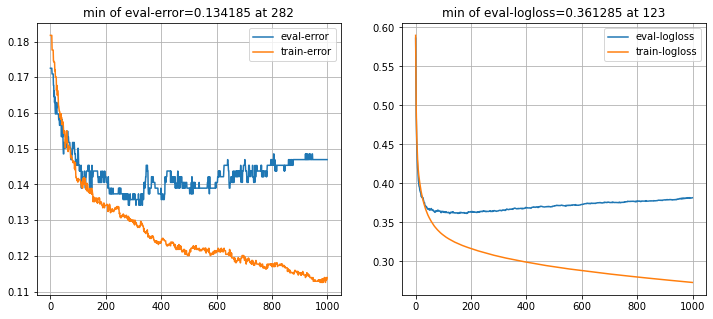

In [8]:
bst=test_xgboost(data_files[0],depth=1,num_round=1000);

data file=Data/processed_data_150mb.np, shape=(41349, 13)


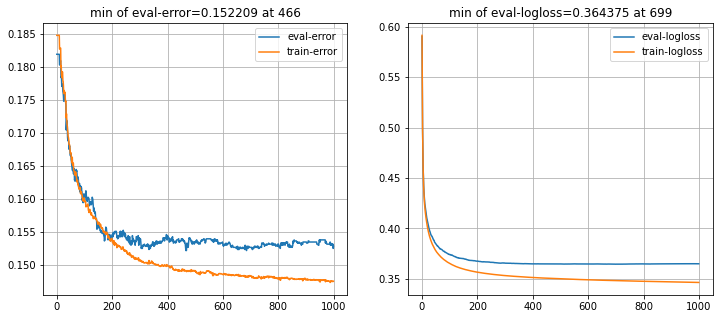

In [9]:
test_xgboost(data_files[1],depth=1,num_round=1000);

### Tree Depth 2

data file=Data/processed_data_15mb.np, shape=(4175, 13)


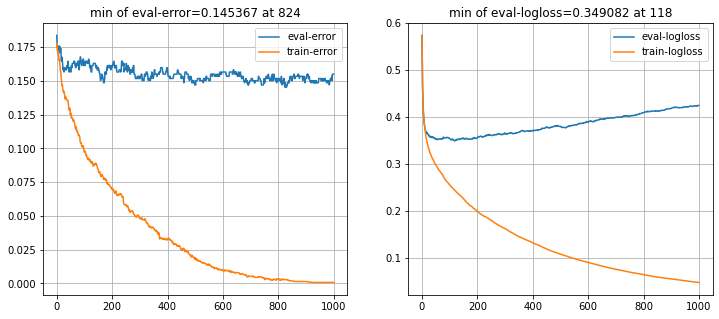

In [10]:
test_xgboost(data_files[0],depth=2,num_round=1000);

data file=Data/processed_data_150mb.np, shape=(41349, 13)


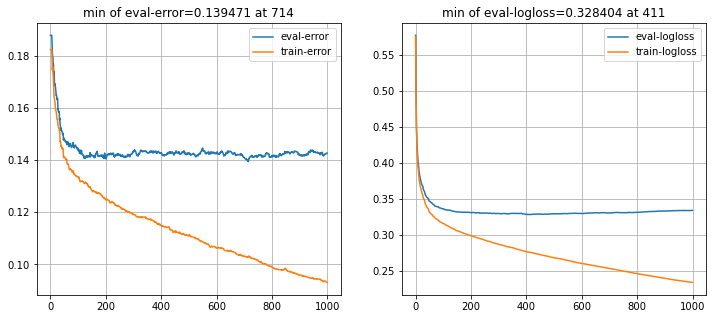

In [11]:
test_xgboost(data_files[1],depth=2,num_round=1000);

### Tree Depth 3

data file=Data/processed_data_15mb.np, shape=(4175, 13)


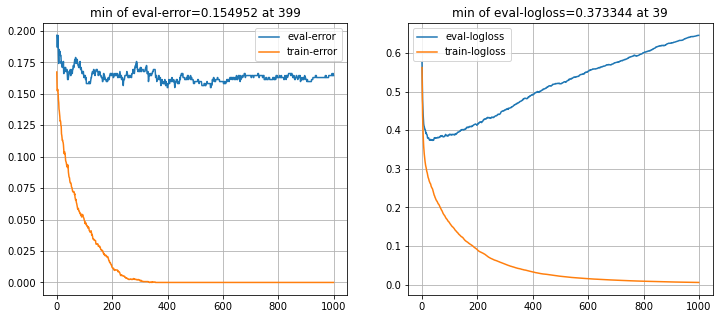

In [12]:
test_xgboost(data_files[0],depth=3,num_round=1000);

data file=Data/processed_data_150mb.np, shape=(41349, 13)


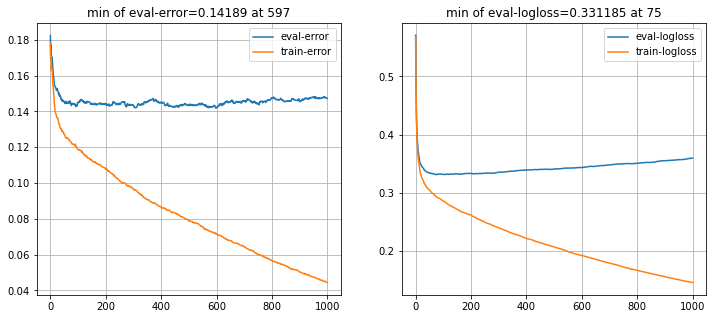

In [13]:
test_xgboost(data_files[1],depth=3,num_round=1000);

### Tree Depth 4

data file=Data/processed_data_15mb.np, shape=(4175, 13)


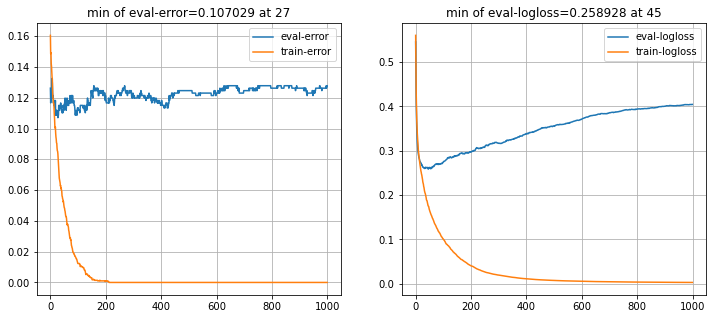

In [14]:
test_xgboost(data_files[0],depth=4,num_round=1000)

data file=Data/processed_data_150mb.np, shape=(41349, 13)


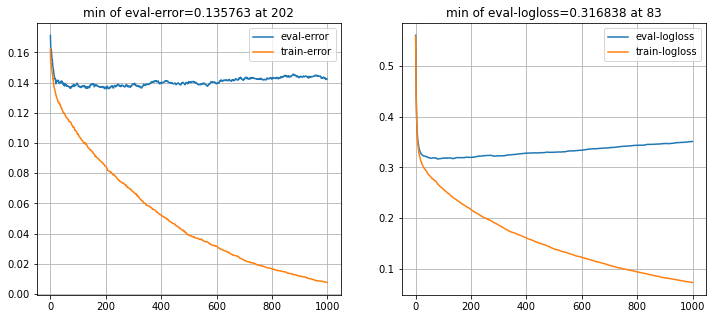

In [15]:
test_xgboost(data_files[1],depth=4,num_round=1000);

### Tree Depth 5

data file=Data/processed_data_15mb.np, shape=(4175, 13)


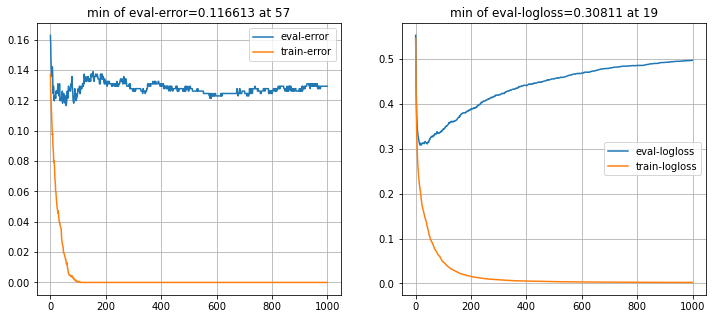

In [16]:
test_xgboost(data_files[0],depth=5,num_round=1000)

data file=Data/processed_data_150mb.np, shape=(41349, 13)


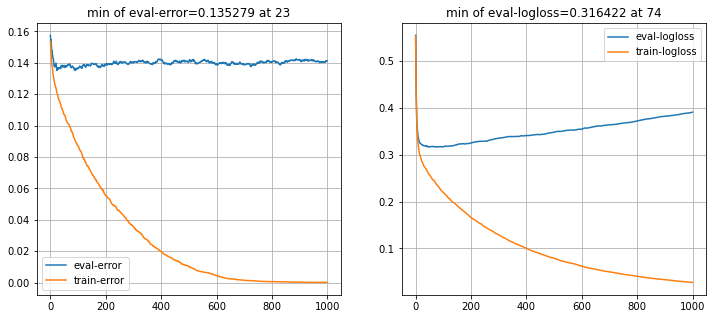

In [17]:
test_xgboost(data_files[1],depth=5,num_round=1000);

## compute ROC

data file=Data/processed_data_150mb.np, shape=(41349, 13)


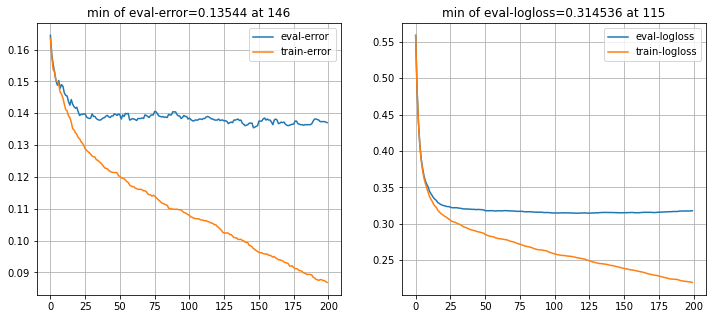

In [18]:
bst=test_xgboost(data_files[1],depth=4,num_round=200);

data file=Data/processed_data_15mb.np, shape=(4175, 13)
data file=Data/processed_data_150mb.np, shape=(41349, 13)
data file=Data/processed_data_150mb.np, shape=(41349, 13)


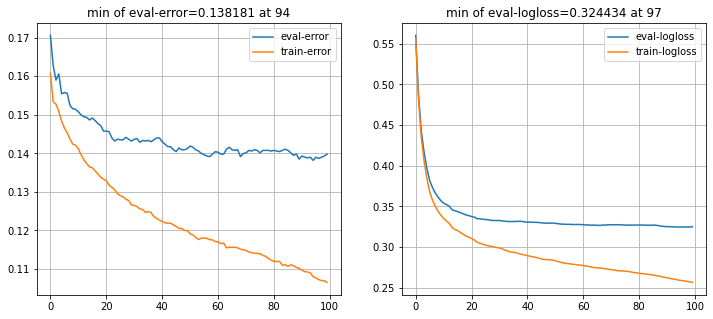

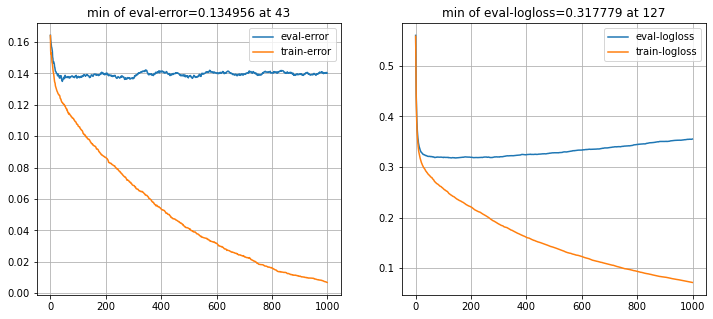

In [19]:
D=DataLoader(filename=data_files[0])
y_test,dtest = D.get(['y_test','dtest'])
bst_100=test_xgboost(data_files[1],depth=4,num_round=100)
y_pred_100 = bst_100.predict(dtest,output_margin=True)
bst_1000=test_xgboost(data_files[1],depth=4,num_round=1000)
y_pred_1000 = bst_1000.predict(dtest,output_margin=True)

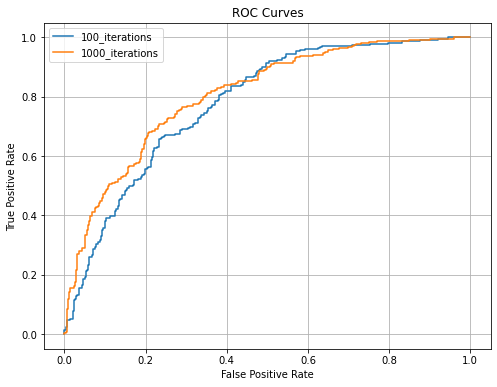

In [20]:
from lib import XGBHelper as xgbh
xgbh.plot_roc(y_test,[(y_pred_100,'100_iterations'),(y_pred_1000,'1000_iterations')])

# Stability of the Margins.
Margins on the training set are predictive of margins of the test set, which is why margins are a better measure of performance than the training error.

* We want to see how variable is the CDF of the scores, as a function of the size of the training set.
* We use bootstrap sampling.
* We plot the CDF for each class for each of the bootstrap samples.

In [21]:
from numpy.random import choice

def bootstrap_sample(X,y):
    assert X.shape[0]==y.shape[0]
    l=X.shape[0]

    C=choice(array(range(l)),l,replace=True)
    Xresamp=X[C]
    yresamp=y[C]
    return Xresamp,yresamp
#bootstrap_sample(X,y)

In [22]:
def plot_margins(X,y,_train_size,ensemble_size=20,TrainingRounds=[10,200],\
                 labels=['Cuviers','Gervais']):
    plt.figure(figsize=(8, 6))
    models={iters:[] for iters in TrainingRounds}

    for i in range(ensemble_size):  #iterate over randomized training of the classifier
        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=_train_size,test_size=1-_train_size)
        X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5)

        dval = xgb.DMatrix(X_val, y_val)
        dtest = xgb.DMatrix(X_test, label=y_test)
        legends=[]

        for num_round in TrainingRounds:  # Number of training iterations
            X_train_bootstrap,y_train_bootstrap=bootstrap_sample(X_train,y_train)
            dtrain = xgb.DMatrix(X_train_bootstrap, label=y_train_bootstrap)
            evallist = [(dtrain, 'train'), (dtest, 'eval')]
            bst = xgb.train(param_D2L(param), dtrain, num_round, evallist, verbose_eval=False)
            
            models[num_round].append(bst)
            y_pred = bst.predict(dtest,output_margin=True)
            thresholds = sorted(np.unique(np.round(y_pred, 2)))
            error_cuv, error_ger = xgbh.get_error_values(y_pred, y_test, thresholds)
            legends += [f'{labels[0]}{num_round}', f'{labels[0]}{num_round}']
            _style=['y','g'] if num_round==10 else ['b', 'r']
            xgbh.get_margin_plot(error_cuv, error_ger, thresholds, legends = legends, style=_style)
        
        plt.grid(which='major', linestyle='-', linewidth='0.5', color='gray')
        plt.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
        thr = thresholds/(np.max(thresholds) - np.min(thresholds))
    plt.title('train size=%4.3f, test size=%4.3f'%(X_train.shape[0],X_test.shape[0]))
    plt.show()
    return models

## Stability Results

data file=Data/processed_data_15mb.np, shape=(4175, 13)


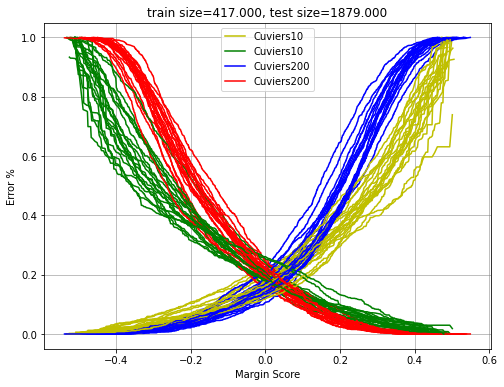

In [23]:
D=DataLoader(data_files[0])
X,y=D.get(['X','y'])
models=plot_margins(X,y,0.1)

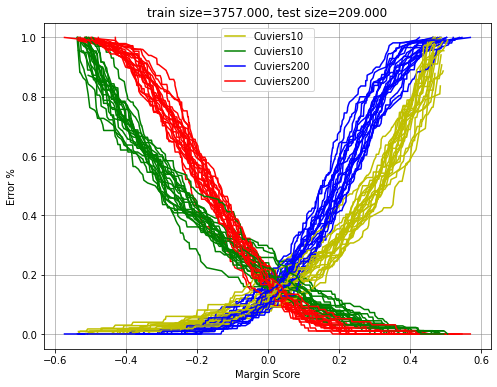

In [24]:
models=plot_margins(X,y,0.9);

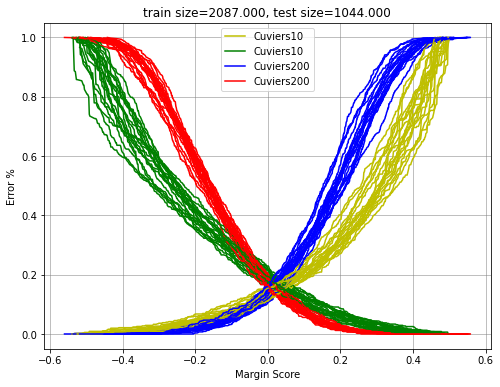

In [25]:
models=plot_margins(X,y,0.5);

data file=Data/processed_data_150mb.np, shape=(41349, 13)


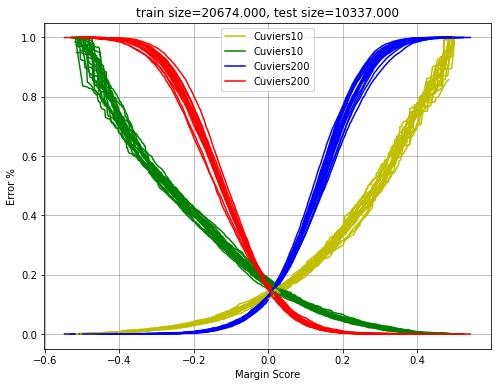

In [26]:
D=DataLoader(data_files[1])
X,y=D.get(['X','y'])
models=plot_margins(X,y,0.5)

# Things to think about
* If you consider the graphs of the error and log loss as a function of the number of boosting iterations, what would you select for tree depth and number of boosting iterations?
* If you consider the same question using the margins plots, what would be your conclusions in that case?
* Suppose the scores are split into three ranges using two threshold, the left threshold and the right threshold. TO the left of the left threshold you predict `Cuviers`, and to the right of the right threshold you predict `Gervais`. Between the two thresholds you don't predict, i.e. you say "I don't know". If you say "I don't know" you lose nothing. If you predict and you are right, you get 1 dollar. and if you predict and you are incorrect you lose 4 dollars. How should you choose the two threshold.

Think about these questions and we'll discuss them in the next class!

# Summary
* We saw how PCA+Boosting are used to solve a real-world problem.

* We saw several ways to quantify and understand the behaviour of boosted trees.
   * Train and test error
   * Train and test loss
   * ROC curves
   * Stability of scores